# Introduction
Uproot tutorial: https://masonproffitt.github.io/uproot-tutorial/aio.html

In [3]:
import numpy as np
import pandas as pd

# The wierd zero problem is fixed with uproot4: https://github.com/scikit-hep/uproot/issues/513
# Therefore, we don't need to use uproot3
import uproot4
import uproot
import math
import time
import timeit

import xgboost as xgb

# First XGBoost model for Pima Indians dataset
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score,auc #算auc用

import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [27]:
from random import randrange
from random import randint

x = [randint(1, 8) for p in range(0, 10)]
print(x)

[7, 8, 7, 4, 3, 2, 6, 3, 8, 4]


# Validation on the random
random integer with step: https://stackoverflow.com/questions/3996904/generate-random-integers-between-0-and-9
count occurance of elements in array: https://stackoverflow.com/questions/21866625/counting-occurrences-of-items-in-an-array-python

i =  300  occurance =  0
i =  400  occurance =  19596
i =  500  occurance =  19826
i =  600  occurance =  20117
i =  700  occurance =  20231
i =  800  occurance =  19966
i =  900  occurance =  20049
i =  1000  occurance =  20215
i =  1100  occurance =  0


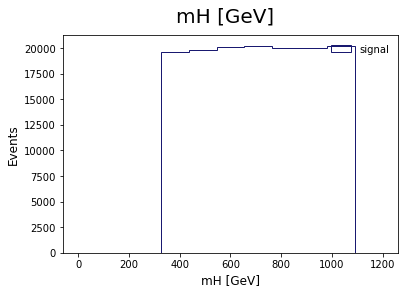

In [56]:
a = np.random.random((140000))
# print(a)
dataframe = pd.DataFrame({'Column1': a})

dataframe['random'] = a

HiggsMassList = [400,500,600,700,800,900,1000,1100]
x = [randrange(400,1100,100) for p in range(0, dataframe.shape[0])]

for i in range(300,1200,100):
    print("i = ", i, " occurance = ", x.count(i))


plt.figure();
plt.hist(x,bins=np.linspace(0,1200,12),
         histtype='step',color='midnightblue',label='signal')
# plt.hist(dataframe.mH,bins=np.linspace(400,1000,7),
#          histtype='step',color='firebrick',label='background')

plt.xlabel('mH [GeV]',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.suptitle('mH [GeV]', fontsize=20)

plt.legend(frameon=False);


In [46]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# fname = "/lustre/umt3/user/metsai/hbsm4top/Offline/SM4t-212830_HBSM4tops_newBDT_syst_offv4_official/mc16a/2lss3lge1mv2c10j/4tops.root"
fname = "/lustre/umt3/user/metsai/hbsm4top/Offline/SM4t-212830_HBSM4tops_newBDT_syst_offv4_official/mc16a/2lss3lge1mv2c10j/vh.root"
tree = uproot.open(fname)["nominal_Loose"]
EventID = uproot4.open(fname)["nominal_Loose"]

# Event ID
runNumber_arr = EventID["runNumber"].array(library="pd")
mcChannelNumber_arr = EventID["mcChannelNumber"].array(library="pd")
eventNumber_arr = EventID["eventNumber"].array(library="pd")

AllVariables=[
            'nJets',
            'nBTags_MV2c10_77',
            'mmm_Zveto',
            'emm_Zveto',
            'eem_Zveto',
            'eee_Zveto',
            'SSmm',
            'SSem_passECIDS',
            'SSee_passECIDS',
            'weight_normalise',
            'weight_mcweight_normalise',
            'weight_pileup',
            'weight_jvt',
            'mc_generator_weights',
            'weight_bTagSF_MV2c10_Continuous_CDI20190730',
            'weight_indiv_SF_EL_ChargeID',
            'weight_mc',
            'weight_leptonSF',
            'isSignalBkg'
            ]

variables = ['met_met','HT_all','deltaR_ll_sum','deltaR_ll_min','SphericityJets','SphericityXYJets']
VariablesList = [item for item in variables]
for var in range(len(VariablesList)):
    AllVariables.append( VariablesList[var] );

dataframe = tree.pandas.df(AllVariables,flatten=False)

dataframe["runNumber"] = runNumber_arr
dataframe["mcChannelNumber"] = mcChannelNumber_arr
dataframe["eventNumber"] = eventNumber_arr
# print(dataframe)

# combine the weights into one and then we can drop all nesty weights
# dataframe['weight'] = (36207.7*(dataframe.runNumber==284500)+44307.4*(dataframe.runNumber==300000)+(dataframe.runNumber==310000)*58450.1)*(1/138965.16)*dataframe.weight_normalise*dataframe.weight_mcweight_normalise.str[85]/dataframe.weight_mcweight_normalise.str[0]*dataframe.weight_pileup*dataframe.weight_jvt*dataframe.mc_generator_weights.str[85]*dataframe.weight_leptonSF*dataframe.weight_bTagSF_MV2c10_Continuous_CDI20190730*(dataframe.weight_indiv_SF_EL_ChargeID*(dataframe.SSee_passECIDS | dataframe.SSem_passECIDS)+1*(~(dataframe.SSee_passECIDS.astype(bool) | dataframe.SSem_passECIDS.astype(bool))).astype(int))
dataframe['weight'] = (36207.7*(dataframe.runNumber==284500)+44307.4*(dataframe.runNumber==300000)+(dataframe.runNumber==310000)*58450.1)*(1/138965.16)*dataframe.weight_normalise*dataframe.weight_pileup*dataframe.weight_jvt*dataframe.weight_mc*dataframe.weight_leptonSF*dataframe.weight_bTagSF_MV2c10_Continuous_CDI20190730*(dataframe.weight_indiv_SF_EL_ChargeID*(dataframe.SSee_passECIDS | dataframe.SSem_passECIDS)+1*(~(dataframe.SSee_passECIDS.astype(bool) | dataframe.SSem_passECIDS.astype(bool))).astype(int))

# See reference: https://stackoverflow.com/questions/30327417/pandas-create-new-column-in-df-with-random-integers-from-range
# Randomly assign Higgs masses for non-BSM 4tops samples
HiggsMassList = [400,500,600,700,800,900,1000]

mH_randomArray = [randrange(400,1100,100) for p in range(0, dataframe.shape[0])]
dataframe['mH'] = mH_randomArray

# Insert the correct Higgs masses for BSM 4tops samples
dataframe.loc[(dataframe['mcChannelNumber'] == 312440) , 'mH'] = 400
dataframe.loc[(dataframe['mcChannelNumber'] == 312441) , 'mH'] = 500
dataframe.loc[(dataframe['mcChannelNumber'] == 312442) , 'mH'] = 600
dataframe.loc[(dataframe['mcChannelNumber'] == 312443) , 'mH'] = 700
dataframe.loc[(dataframe['mcChannelNumber'] == 312444) , 'mH'] = 800
dataframe.loc[(dataframe['mcChannelNumber'] == 312445) , 'mH'] = 900
dataframe.loc[(dataframe['mcChannelNumber'] == 312446) , 'mH'] = 1000

print(dataframe)
# Drop the variables for the nesty weights
# WeightVariables = [ 'weight_normalise',
#                     'weight_mcweight_normalise',
#                     'weight_pileup',
#                     'weight_jvt',
#                     'mc_generator_weights',
#                     'weight_bTagSF_MV2c10_Continuous_CDI20190730',
#                     'weight_indiv_SF_EL_ChargeID',
#                     'weight_mc',
#                     'weight_leptonSF']
# dataframe = dataframe.drop(columns=WeightVariables)


# # Apply the selections (two-fold validation, even and odd)
# # See the intro: https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html
# Presel_df = Preselection(dataframe)

# # After preselection
# Variables=['nJets','nBTags_MV2c10_77','mmm_Zveto','emm_Zveto','eem_Zveto','eee_Zveto','SSmm','SSem_passECIDS','SSee_passECIDS','runNumber']
# Presel_df = Presel_df.drop(columns=Variables)
# # https://stackoverflow.com/questions/25649429/how-to-swap-two-dataframe-columns
# DefaultVar = ['eventNumber', 'isSignalBkg', 'weight', 'mH', 'mcChannelNumber']
# for var in range(len(DefaultVar)):
#     VariablesList.append( DefaultVar[var] );
# Presel_df=Presel_df.reindex(columns=VariablesList)

# # print("Presel_df = \n\n", Presel_df)

# # outputfolder = args.outputfolder
# # outputfile = args.outputfile
# # Presel_df.to_csv(outputfolder+outputfile)


       nJets  nBTags_MV2c10_77  mmm_Zveto  emm_Zveto  eem_Zveto  eee_Zveto  \
entry                                                                        
0          2                 1          0          0          0          0   
1          1                 1          0          0          0          0   
2          2                 1          0          0          0          0   
3          1                 1          0          0          0          0   
4          1                 1          0          0          0          0   
5          1                 1          0          0          0          0   
6          4                 1          0          0          0          0   
7          1                 1          0          0          0          0   
8          2                 1          0          0          0          0   
9          1                 1          0          0          0          0   
10         1                 1          0          0          0 

In [ ]:
plt.figure();
plt.hist(Presel_df.mH[Presel_df.isSignalBkg == 1],bins=np.linspace(400,1000,7),
         histtype='step',color='midnightblue',label='signal');
plt.hist(Presel_df.mH[Presel_df.isSignalBkg == 0],bins=np.linspace(400,1000,7),
         histtype='step',color='firebrick',label='background');

plt.xlabel('mH [GeV]',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.suptitle('mH [GeV]', fontsize=20)

plt.legend(frameon=False);
